In [135]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rnn-dataset-for-fake-news-detection/True.csv
/kaggle/input/rnn-dataset-for-fake-news-detection/Fake.csv


In [136]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras_tuner.tuners import RandomSearch, BayesianOptimization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [137]:
fake_df = pd.read_csv('/kaggle/input/rnn-dataset-for-fake-news-detection/Fake.csv')
real_df = pd.read_csv('/kaggle/input/rnn-dataset-for-fake-news-detection/True.csv')

In [138]:
#Checking for null values

In [139]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [140]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [141]:
##Checking for unique values for subject. We want both data frames to have a similar distribution.



In [142]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [143]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [144]:
##Drop the date from the dataset. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well.

In [145]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

In [146]:
## Define the target variable/label as class ,0 for fake news, and 1 for real news

In [147]:
fake_df['class'] = 0 
real_df['class'] = 1

In [148]:
##Check out the distribution of fake news compare to real news

Text(0, 0.5, 'Proportion of News Articles')

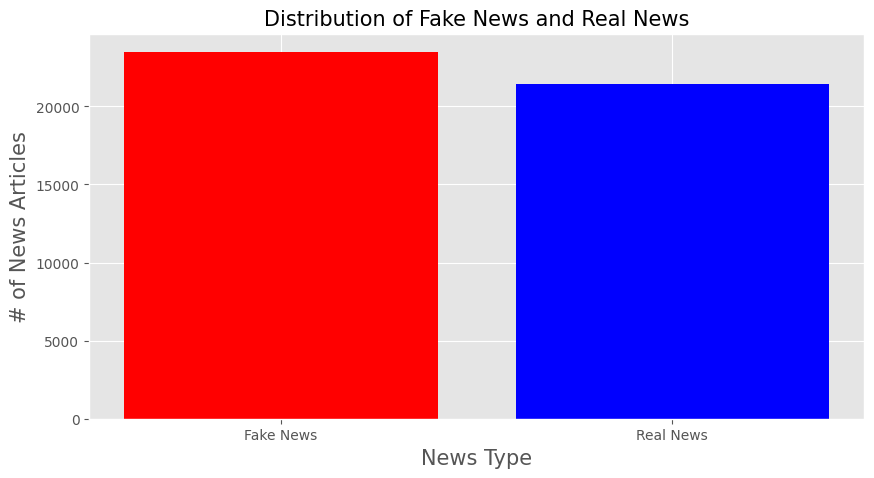

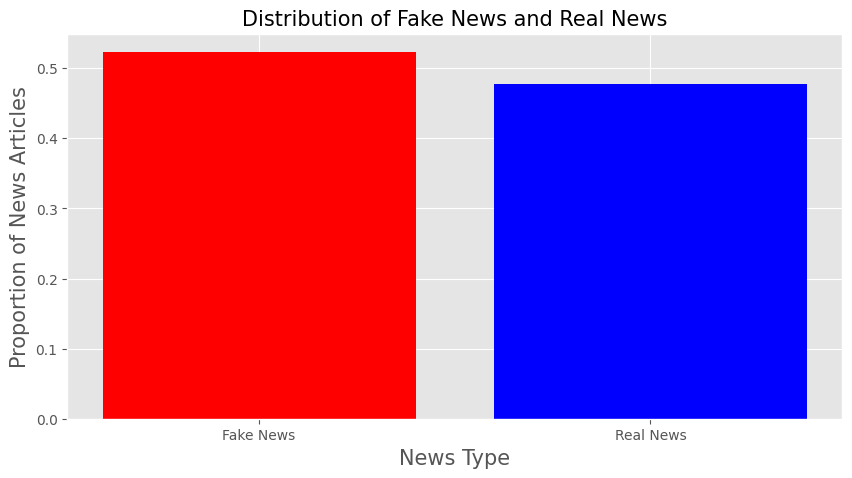

In [149]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='red')
plt.bar('Real News', len(real_df), color='blue')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='red')
plt.bar('Real News', len(real_df) / total_len, color='blue')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [150]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [151]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [152]:
## Combining the title with the text, it is much easier to process this way.

In [153]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [154]:
# Split into training and testing

In [155]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [156]:
## Normalizing our data: lower case, get rid of extra spaces, and url links.

In [157]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [158]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [159]:
##  Since the classifier takes numerical data only so we convert text to vectors.

In [160]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [162]:
## Apply padding so we have the same length for each article

In [163]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [164]:
## Building the RNN.The RNN model consists of an embedding layer, an LSTM layer with dropout for regularization, and a dense layer for classification.

In [165]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_6 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [167]:
## We are going to use early stop, which stops when the validation loss no longer improve.

In [168]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 215s 194ms/step - loss: 0.2432 - accuracy: 0.8750 - val_loss: 0.0635 - val_accuracy: 0.9822
Epoch 2/10
1078/1078 [==============================] - 212s 197ms/step - loss: 0.0474 - accuracy: 0.9877 - val_loss: 0.0392 - val_accuracy: 0.9875
Epoch 3/10
1078/1078 [==============================] - 213s 197ms/step - loss: 0.0226 - accuracy: 0.9949 - val_loss: 0.0328 - val_accuracy: 0.9883
Epoch 4/10
1078/1078 [==============================] - 212s 196ms/step - loss: 0.0124 - accuracy: 0.9976 - val_loss: 0.0339 - val_accuracy: 0.9919
Epoch 5/10
1078/1078 [==============================] - 213s 198ms/step - loss: 0.0099 - accuracy: 0.9977 - val_loss: 0.0370 - val_accuracy: 0.9911


In [34]:
##Visualize our training over time

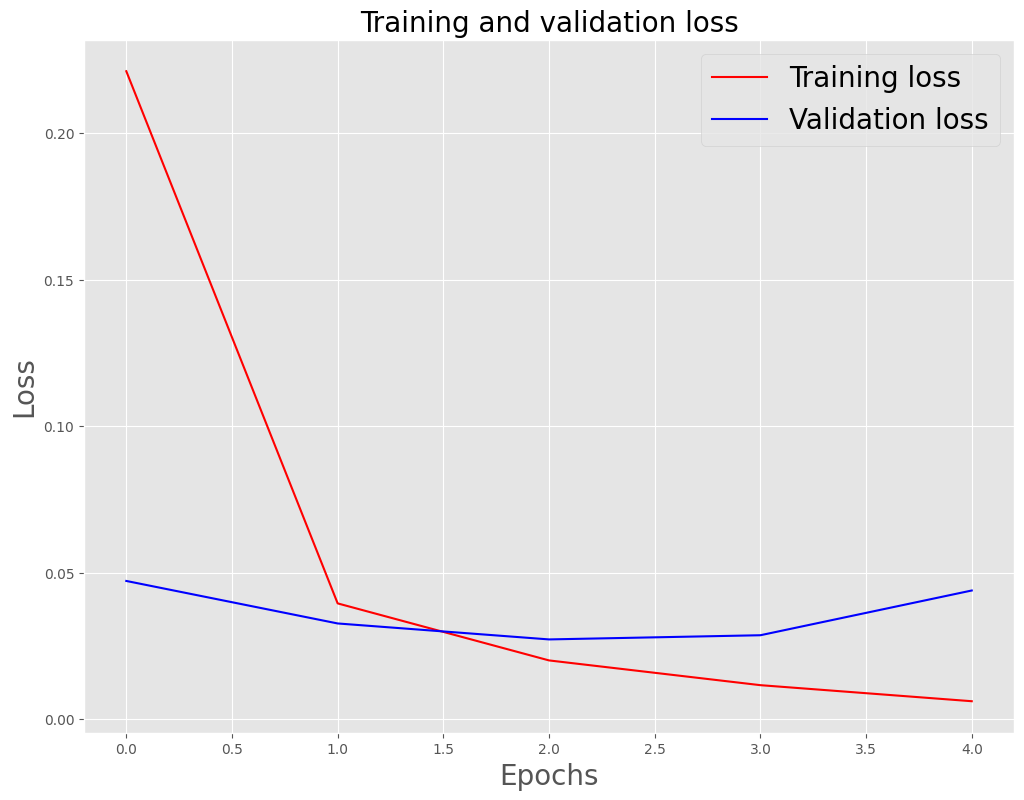

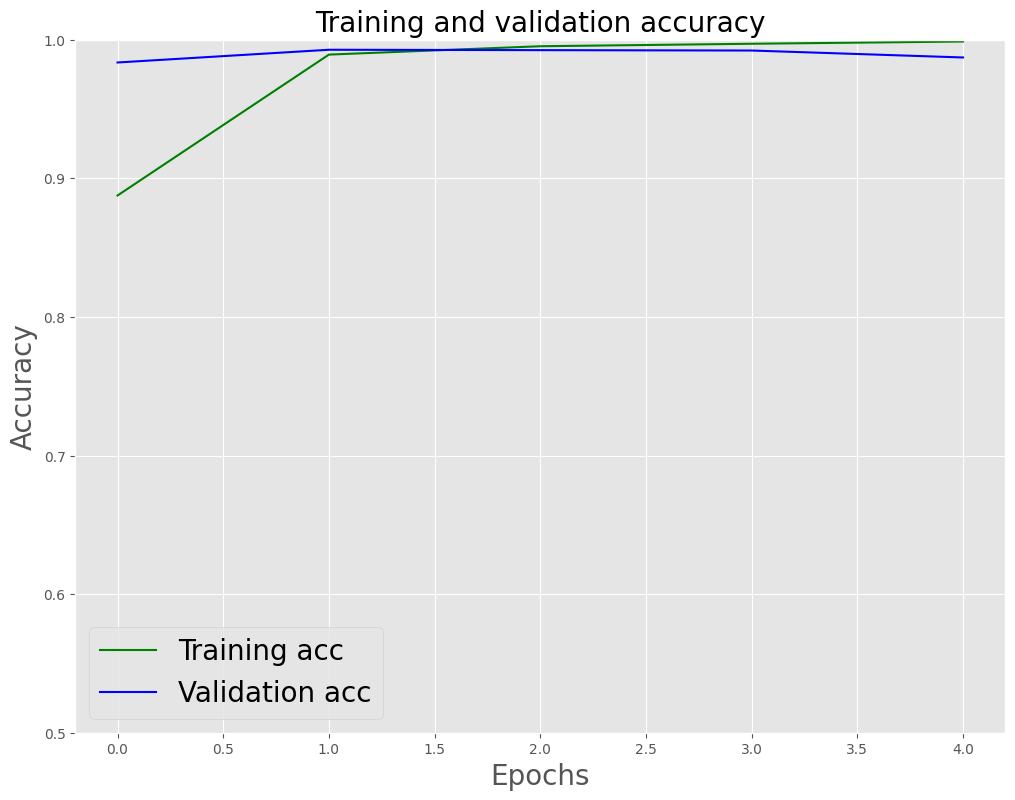

In [35]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [36]:
## Evaluate the testing set

In [37]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 21s 76ms/step - loss: 0.0371 - accuracy: 0.9894


[0.0371316559612751, 0.9894209504127502]

In [38]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 23s 76ms/step


In [39]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9894209354120267
Precision on testing set: 0.990968040759611
Recall on testing set: 0.9870818915801615


In [40]:
# Manual testing
from tensorflow.keras.preprocessing.sequence import pad_sequences

def manual_test(model, tokenizer):
    user_input = input("Enter a news article for fake news detection: ")

    # Preprocess user input
    text_seq = tokenizer.texts_to_sequences([user_input])
    text_padded = pad_sequences(text_seq, padding='post', maxlen=256)  # Use the same maxlen as in training

    # Make prediction
    prediction = model.predict(text_padded)
    prediction_label = 1 if prediction > 0.5 else 0

    print(f'Prediction for "{user_input}": {prediction_label}')
    print(f'Prediction for "{user_input}": {prediction_label}')


In [48]:
# Example of manual testing
manual_test(model, tokenizer)

Enter a news article for fake news detection:  Thousands of people forced out of homes after 7.1 quake hit western China The earthquake caused significant damage amid freezing temperatures, but the toll on lives and property was relatively light, owing to the sparse population around the epicentre in Uchturpan county, near the border with Kazakhstan. January 24, 2024 12:48 pm | Updated 01:17 pm IST - Uchturpan (China)


1/1 [==============================] - 0s 66ms/step
Prediction for "Thousands of people forced out of homes after 7.1 quake hit western China The earthquake caused significant damage amid freezing temperatures, but the toll on lives and property was relatively light, owing to the sparse population around the epicentre in Uchturpan county, near the border with Kazakhstan. January 24, 2024 12:48 pm | Updated 01:17 pm IST - Uchturpan (China)": 1
Prediction for "Thousands of people forced out of homes after 7.1 quake hit western China The earthquake caused significant damage amid freezing temperatures, but the toll on lives and property was relatively light, owing to the sparse population around the epicentre in Uchturpan county, near the border with Kazakhstan. January 24, 2024 12:48 pm | Updated 01:17 pm IST - Uchturpan (China)": 1


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

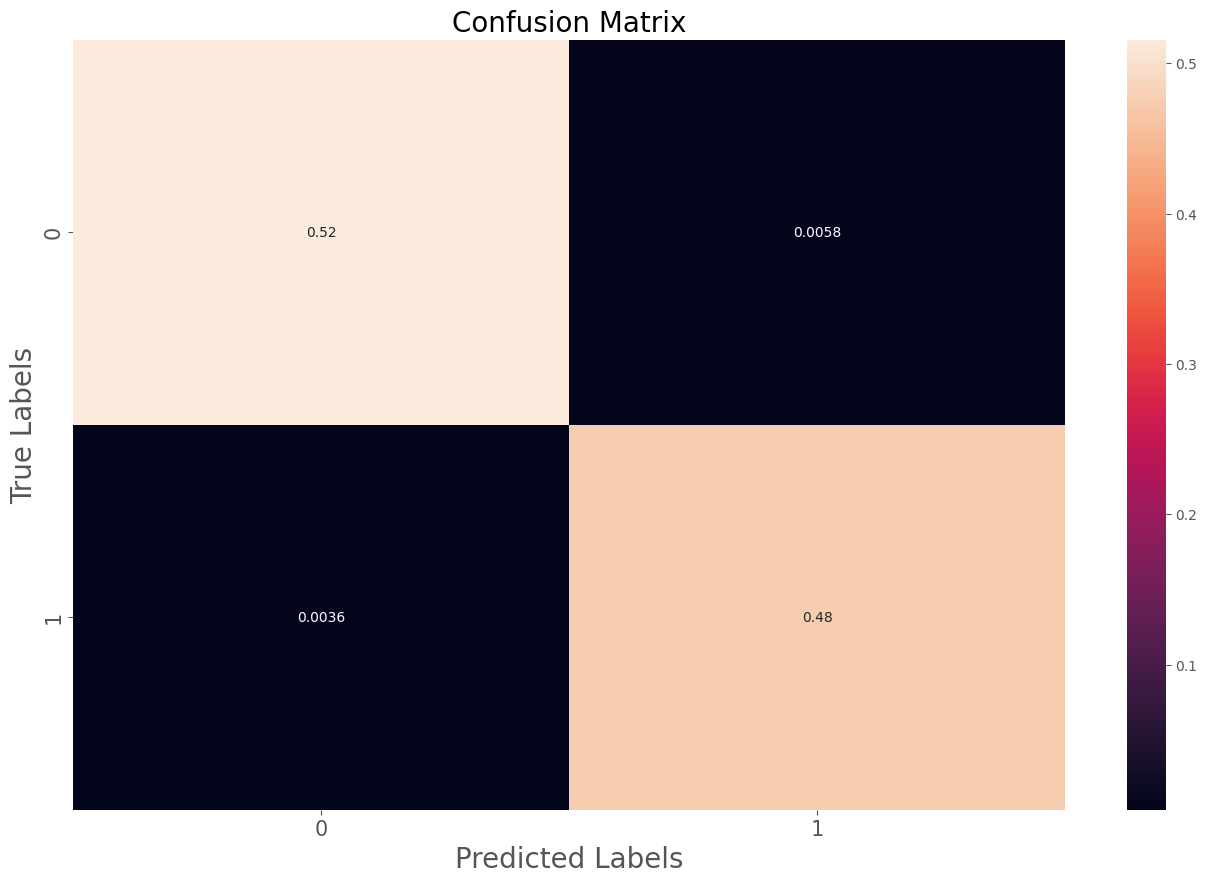

In [41]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)